In [2]:
import pylaeoclim_leeds.util_hadcm3 as util
import pylaeoclim_leeds.hadcm3_processing as hcm3
import pylaeoclim_leeds.processing as proc
import pylaeoclim_leeds.zones as zones
import xarray as xr
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cftime
import numpy as np
import SCM6
import matplotlib.colors as colors

# WEIGHTED MEAN - equilibrium plots

**GOAL**: Update hadcm3_processing to import bounds.

**Problems**: Each dataset has its own coordinate system. Case by case before moving to something more global?

**To be done**: New coordinate import system, from scratch!! There is no need to crop the coordinates.

## HadCM3 bounds

**Top atmosphere (pc)**

In [3]:
def transform(array_r):
    array = array_r
    if "longitude" in array.dims:
        array = xr.concat([array, array.isel(longitude=0)], dim="longitude")
    if "longitude_1" in array.dims:
        array = xr.concat([array, array.isel(longitude_1=0)], dim="longitude_1")
    if "latitude" in array.dims:
        array.isel(latitude=-1).values
        array = xr.concat([array.isel(latitude=0),array, array.isel(latitude=-1)], dim="latitude")
    return array.transpose(*array_r.dims)

In [4]:
ds = xr.open_dataset("/nfs/see-fs-01_users/eeymr/dump2hold/xosfd/pcpd/xosfda#pc000001200ja+.nc")
ds

<xarray.Dataset>
Dimensions:      (latitude: 72, latitude_1: 73, longitude: 96, longitude_1: 96, p: 17, t: 1)
Coordinates:
  * longitude    (longitude) float32 1.875 5.625 9.375 ... 354.375 358.125
  * latitude     (latitude) float32 88.75 86.25 83.75 ... -83.75 -86.25 -88.75
  * p            (p) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * t            (t) object 1200-01-16 00:00:00
  * longitude_1  (longitude_1) float32 0.0 3.75 7.5 ... 348.75 352.5 356.25
  * latitude_1   (latitude_1) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Data variables:
    omega_mm_p   (t, p, latitude, longitude) float32 ...
    u_mm_p       (t, p, latitude, longitude) float32 ...
    v_mm_p       (t, p, latitude, longitude) float32 ...
    q_mm_p       (t, p, latitude, longitude) float32 ...
    uq_mm_p      (t, p, latitude, longitude) float32 ...
    vq_mm_p      (t, p, latitude, longitude) float32 ...
    ht_mm_p      (t, p, latitude_1, longitude_1) float32 ...
    temp_mm_p    (t, p, latitude_1, longitude_1) float32 ...
    rh_mm_p      (t, p, latitude_1, longitude_1) float32 ...
Attributes:
    history:  Wed Jun 17 20:16:57 BST 2020 - XCONV V1.91 Development

In [5]:
lon, lonb = np.sort(ds.longitude.values), np.sort(ds.longitude_1.values)
lons = lonb[1:]-lonb[0:-1]
lon_p = np.append(lon,lon[-1]+lons[-1])
lonb_p = np.append(lonb,2*lonb[-1]-lonb[-2])
lons_p = lonb_p[1:]-lonb_p[0:-1]

print(f"lon: [{lon[0]}; {lon[1]}; ... ; {lon[-2]}; {lon[-1]}; {len(lon)}]")
print(f"lon_p: [{lon_p[0]}; {lon_p[1]}; ... ; {lon_p[-2]}; {lon_p[-1]}; {len(lon_p)}]")
print(f"lonb: [{lonb[0]}; {lonb[1]}; ... ; {lonb[-2]}; {lonb[-1]}; {len(lonb)}]")
print(f"lonb_p: [{lonb_p[0]}; {lonb_p[1]}; ... ; {lonb_p[-2]}; {lonb_p[-1]}; {len(lonb_p)}]")
print(f"lons: [{lons[0]}; {lons[1]}; ... ; {lons[-2]}; {lons[-1]}; {len(lons)}]")
print(f"lons_p: [{lons_p[0]}; {lons_p[1]}; ... ; {lons_p[-2]}; {lons_p[-1]}; {len(lons_p)}]")

lon: [1.875; 5.625; ... ; 354.375; 358.125; 96]
lon_p: [1.875; 5.625; ... ; 358.125; 361.875; 97]
lonb: [0.0; 3.75; ... ; 352.5; 356.25; 96]
lonb_p: [0.0; 3.75; ... ; 356.25; 360.0; 97]
lons: [3.75; 3.75; ... ; 3.75; 3.75; 95]
lons_p: [3.75; 3.75; ... ; 3.75; 3.75; 96]


In [6]:
lat, latb = np.sort(ds.latitude.values), np.sort(ds.latitude_1.values)
lats = latb[1:]-latb[0:-1]
lat_p =  np.concatenate(([-90], lat, [90]))
latb_p = latb
lats_p = latb_p[1:]-latb_p[0:-1]

print(f"lat: [{lat[0]}; {lat[1]}; ... ; {lat[-2]}; {lat[-1]}; {len(lat)}]")
print(f"lat_p: [{lat_p[0]}; {lat_p[1]}; ... ; {lat_p[-2]}; {lat_p[-1]}; {len(lat_p)}]")
print(f"latb: [{latb[0]}; {latb[1]}; ... ; {latb[-2]}; {latb[-1]}; {len(latb)}]")
print(f"latb_p: [{latb_p[0]}; {latb_p[1]}; ... ; {latb_p[-2]}; {latb_p[-1]}; {len(latb_p)}]")
print(f"lats: [{lats[0]}; {lats[1]}; ... ; {lats[-2]}; {lats[-1]}; {len(lats)}]")
print(f"lats_p: [{lats_p[0]}; {lats_p[1]}; ... ; {lats_p[-2]}; {lats_p[-1]}; {len(lats_p)}]")

lat: [-88.75; -86.25; ... ; 86.25; 88.75; 72]
lat_p: [-90.0; -88.75; ... ; 88.75; 90.0; 74]
latb: [-90.0; -87.5; ... ; 87.5; 90.0; 73]
latb_p: [-90.0; -87.5; ... ; 87.5; 90.0; 73]
lats: [2.5; 2.5; ... ; 2.5; 2.5; 72]
lats_p: [2.5; 2.5; ... ; 2.5; 2.5; 72]


In [7]:
z= np.sort(ds.p.values)
zs = z[1:]-z[0:-1]
zb = np.concatenate((z[:-1]-zs/2, [z[-1]-zs[-1]/2], [z[-1]+zs[-1]/2]))
z_p =  z
zb_p = zb
zs_p = zb_p[1:]-zb_p[0:-1]

print(f"z: [{z[0]}; {z[1]}; ... ; {z[-2]}; {z[-1]}; {len(z)}]")
print(f"z_p: [{z_p[0]}; {z_p[1]}; ... ; {z_p[-2]}; {z_p[-1]}; {len(z_p)}]")
print(f"zb: [{zb[0]}; {zb[1]}; ... ; {zb[-2]}; {zb[-1]}; {len(zb)}]")
print(f"zb_p: [{zb_p[0]}; {zb_p[1]}; ... ; {zb_p[-2]}; {zb_p[-1]}; {len(zb_p)}]")
print(f"zs: [{zs[0]}; {zs[1]}; ... ; {zs[-2]}; {zs[-1]}; {len(zs)}]")
print(f"zs_p: [{zs_p[0]}; {zs_p[1]}; ... ; {zs_p[-2]}; {zs_p[-1]}; {len(zs_p)}]")

z: [10.0; 20.0; ... ; 925.0; 1000.0; 17]
z_p: [10.0; 20.0; ... ; 925.0; 1000.0; 17]
zb: [5.0; 15.0; ... ; 962.5; 1037.5; 18]
zb_p: [5.0; 15.0; ... ; 962.5; 1037.5; 18]
zs: [10.0; 10.0; ... ; 75.0; 75.0; 16]
zs_p: [10.0; 5.0; ... ; 75.0; 75.0; 17]


In [7]:
temperature_r = ds.temp_mm_p.isel(t=0).drop("t").isel(p=0).drop("p")
temperature = transform(temperature_r)

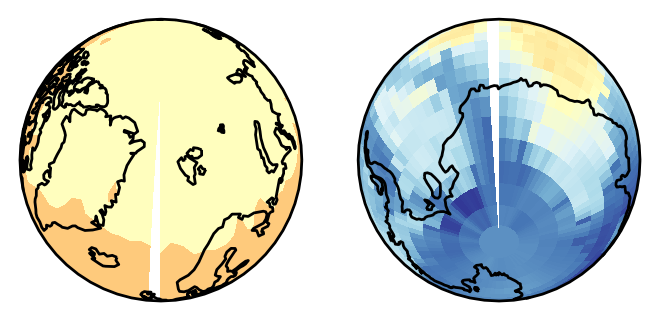

In [8]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb, latb, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb, latb, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

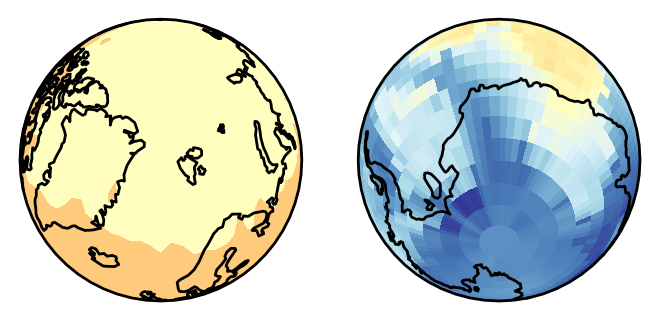

In [9]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,5), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb_p, latb_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb_p, latb_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

with depth

In [10]:
temperature_r = ds.temp_mm_p.isel(t=0).drop("t").isel(longitude_1=90).drop("longitude_1")
temperature = transform(temperature_r)

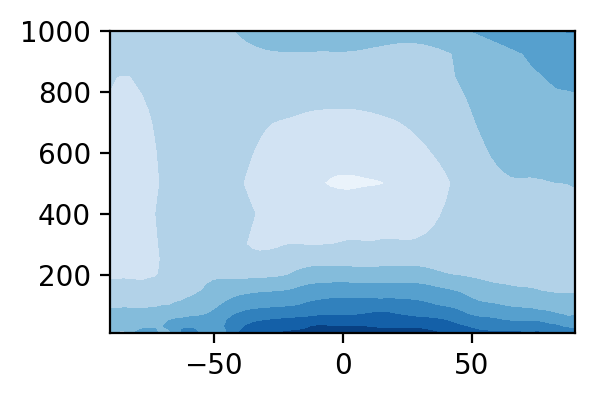

In [11]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(latb, z, temperature_r, cmap='Blues')

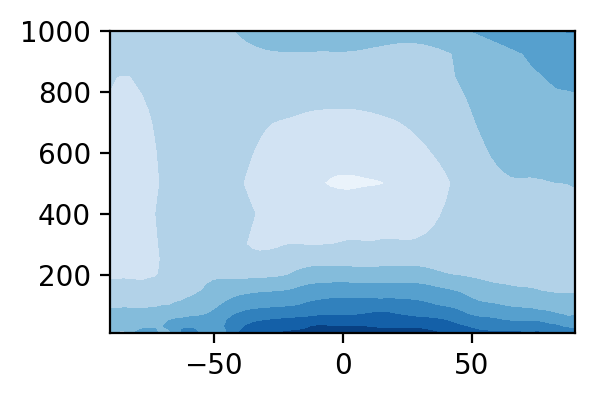

In [12]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(latb_p, z_p, temperature, cmap='Blues')

and with latitude and longitude

In [13]:
humidity_r = ds.q_mm_p.isel(t=0).drop("t").isel(p=0).drop("p")
humidity = transform(humidity_r)

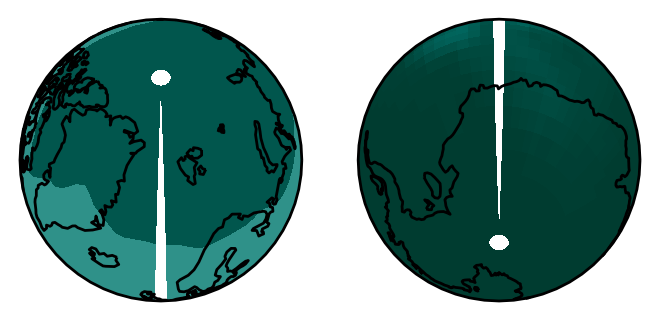

In [14]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon, lat, humidity_r, transform=ccrs.PlateCarree(), cmap="BrBG_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon, lat, humidity_r, transform=ccrs.PlateCarree(), cmap="BrBG_r")
axSouth.coastlines()
axSouth.set_global()

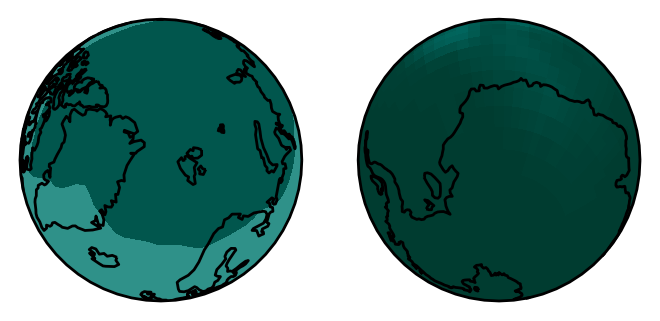

In [15]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon_p, lat_p, humidity, transform=ccrs.PlateCarree(), cmap="BrBG_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon_p, lat_p, humidity, transform=ccrs.PlateCarree(), cmap="BrBG_r")
axSouth.coastlines()
axSouth.set_global()

**DONE!!!**

**Surface atmosphere (pd)**

In [16]:
def transform(array_r):
    array = array_r
    if "longitude" in array.dims:
        array = xr.concat([array, array.isel(longitude=0)], dim="longitude")
    if "longitude_1" in array.dims:
        array = xr.concat([array, array.isel(longitude_1=0)], dim="longitude_1")
    if "latitude_1" in array.dims:
        array.isel(latitude_1=-1).values = array.isel(latitude_1=-2).values
        array = xr.concat([array.isel(latitude_1=0), array,array.isel(latitude_1=-2)], dim="latitude_1")
    return array.transpose(*array_r.dims)

In [17]:
ds = xr.open_dataset("/nfs/see-fs-01_users/eeymr/dump2hold/xosfd/pcpd/xosfda#pd000001200ja+.nc")
ds

<xarray.Dataset>
Dimensions:                   (ht: 1, hybrid_p_x1000: 1, hybrid_p_x1000_1: 1, latitude: 73, latitude_1: 72, level275: 1, level6: 4, longitude: 96, longitude_1: 96, msl: 1, surface: 1, t: 1, toa: 1, unspecified: 1)
Coordinates:
  * longitude                 (longitude) float32 0.0 3.75 7.5 ... 352.5 356.25
  * latitude                  (latitude) float32 90.0 87.5 85.0 ... -87.5 -90.0
  * unspecified               (unspecified) float32 -1.0
  * t                         (t) object 1200-01-16 00:00:00
  * hybrid_p_x1000            (hybrid_p_x1000) float32 996.9989
  * surface                   (surface) float32 0.0
  * toa                       (toa) float32 0.0
  * hybrid_p_x1000_1          (hybrid_p_x1000_1) float32 1000.0
  * longitude_1               (longitude_1) float32 1.875 5.625 ... 358.125
  * latitude_1                (latitude_1) float32 88.75 86.25 ... -86.25 -88.75
  * ht                        (ht) float32 -1.0
  * level275                  (level275) float32 -1.0
  * level6                    (level6) float32 1.0 2.0 3.0 4.0
  * msl                       (msl) float32 0.0
Data variables:
    totCloud_mm_ua            (t, unspecified, latitude, longitude) float32 ...
    Tw_mm_hyb                 (t, hybrid_p_x1000, latitude, longitude) float32 ...
    solar_mm_s3_srf           (t, surface, latitude, longitude) float32 ...
    downSol_mm_TOA            (t, toa, latitude, longitude) float32 ...
    upSol_mm_s3_TOA           (t, toa, latitude, longitude) float32 ...
    clrskyUpSol_mm_s3_TOA     (t, toa, latitude, longitude) float32 ...
    clrskyDownSol_mm_s3_srf   (t, surface, latitude, longitude) float32 ...
    clrskyUpSol_mm_s3_srf     (t, surface, latitude, longitude) float32 ...
    downSol_Seaice_mm_s3_srf  (t, surface, latitude, longitude) float32 ...
    longwave_mm_s3_srf        (t, surface, latitude, longitude) float32 ...
    olr_mm_s3_TOA             (t, toa, latitude, longitude) float32 ...
    csolr_mm_s3_TOA           (t, toa, latitude, longitude) float32 ...
    ilr_mm_s3_srf             (t, surface, latitude, longitude) float32 ...
    csilr_mm_s3_srf           (t, surface, latitude, longitude) float32 ...
    atmosCorr_mm_ua           (t, unspecified, latitude, longitude) float32 ...
    sh_mm_hyb                 (t, hybrid_p_x1000_1, latitude, longitude) float32 ...
    taux_mm_hyb               (t, hybrid_p_x1000_1, latitude_1, longitude_1) float32 ...
    tauy_mm_hyb               (t, hybrid_p_x1000_1, latitude_1, longitude_1) float32 ...
    u_mm_10m                  (t, ht, latitude_1, longitude_1) float32 ...
    v_mm_10m                  (t, ht, latitude_1, longitude_1) float32 ...
    evapsea_mm_srf            (t, surface, latitude, longitude) float32 ...
    lh_mm_srf                 (t, surface, latitude, longitude) float32 ...
    temp_mm_1_5m              (t, ht, latitude, longitude) float32 ...
    q_mm_1_5m                 (t, ht, latitude, longitude) float32 ...
    rh_mm_1_5m                (t, ht, latitude, longitude) float32 ...
    dewT_mm_1_5m              (t, ht, latitude, longitude) float32 ...
    soilEvap_mm_srf           (t, surface, latitude, longitude) float32 ...
    canopyEvap_mm_can         (t, level275, latitude, longitude) float32 ...
    srfSublim_mm_srf          (t, surface, latitude, longitude) float32 ...
    transpiration_mm_srf      (t, surface, latitude, longitude) float32 ...
    lsrain_mm_srf             (t, surface, latitude, longitude) float32 ...
    lssnow_mm_srf             (t, surface, latitude, longitude) float32 ...
    cvrain_mm_srf             (t, surface, latitude, longitude) float32 ...
    cvsnow_mm_srf             (t, surface, latitude, longitude) float32 ...
    precip_mm_srf             (t, surface, latitude, longitude) float32 ...
    sm_mm_soil                (t, level6, latitude, longitude) float32 ...
    soiltemp_mm_soil          (t, level6, latitude, longitude) float32 ...
    srfRunoff_mm_srf          (t, surface, la

In [18]:
lon, lonb = np.sort(ds.longitude.values), np.sort(ds.longitude_1.values)
lons = lonb[1:]-lonb[0:-1]
lon_p = np.append(lon,lon[-1]+lons[-1])
lonb_p = np.append(lonb, [2*lonb[-1] - lonb[-2]])
lons_p = lonb_p[1:]-lonb_p[0:-1]

print(f"lon: [{lon[0]}; {lon[1]}; ... ; {lon[-2]}; {lon[-1]}; {len(lon)}]")
print(f"lon_p: [{lon_p[0]}; {lon_p[1]}; ... ; {lon_p[-2]}; {lon_p[-1]}; {len(lon_p)}]")
print(f"lonb: [{lonb[0]}; {lonb[1]}; ... ; {lonb[-2]}; {lonb[-1]}; {len(lonb)}]")
print(f"lonb_p: [{lonb_p[0]}; {lonb_p[1]}; ... ; {lonb_p[-2]}; {lonb_p[-1]}; {len(lonb_p)}]")
print(f"lons: [{lons[0]}; {lons[1]}; ... ; {lons[-2]}; {lons[-1]}; {len(lons)}]")
print(f"lons_p: [{lons_p[0]}; {lons_p[1]}; ... ; {lons_p[-2]}; {lons_p[-1]}; {len(lons_p)}]")

lon: [0.0; 3.75; ... ; 352.5; 356.25; 96]
lon_p: [0.0; 3.75; ... ; 356.25; 360.0; 97]
lonb: [1.875; 5.625; ... ; 354.375; 358.125; 96]
lonb_p: [1.875; 5.625; ... ; 358.125; 361.875; 97]
lons: [3.75; 3.75; ... ; 3.75; 3.75; 95]
lons_p: [3.75; 3.75; ... ; 3.75; 3.75; 96]


In [19]:
lat, latb = np.sort(ds.latitude.values), np.sort(ds.latitude_1.values)
lats = latb[1:]-latb[0:-1]
lat_p = lat
latb_p = np.concatenate(([-90], latb, [2*latb[-1] - latb[-2]]))
lats_p = latb_p[1:]-latb_p[0:-1]

print(f"lat: [{lat[0]}; {lat[1]}; ... ; {lat[-2]}; {lat[-1]}; {len(lat)}]")
print(f"lat_p: [{lat_p[0]}; {lat_p[1]}; ... ; {lat_p[-2]}; {lat_p[-1]}; {len(lat_p)}]")
print(f"latb: [{latb[0]}; {latb[1]}; ... ; {latb[-2]}; {latb[-1]}; {len(latb)}]")
print(f"latb_p: [{latb_p[0]}; {latb_p[1]}; ... ; {latb_p[-2]}; {latb_p[-1]}; {len(latb_p)}]")
print(f"lats: [{lats[0]}; {lats[1]}; ... ; {lats[-2]}; {lats[-1]}; {len(lats)}]")
print(f"lats_p: [{lats_p[0]}; {lats_p[1]}; ... ; {lats_p[-2]}; {lats_p[-1]}; {len(lats_p)}]")

lat: [-90.0; -87.5; ... ; 87.5; 90.0; 73]
lat_p: [-90.0; -87.5; ... ; 87.5; 90.0; 73]
latb: [-88.75; -86.25; ... ; 86.25; 88.75; 72]
latb_p: [-90.0; -88.75; ... ; 88.75; 91.25; 74]
lats: [2.5; 2.5; ... ; 2.5; 2.5; 71]
lats_p: [1.25; 2.5; ... ; 2.5; 2.5; 73]


In [20]:
temperature_r = ds.temp_mm_srf.isel(t=0).drop("t").isel(surface=0).drop("surface")
temperature = transform(temperature_r)

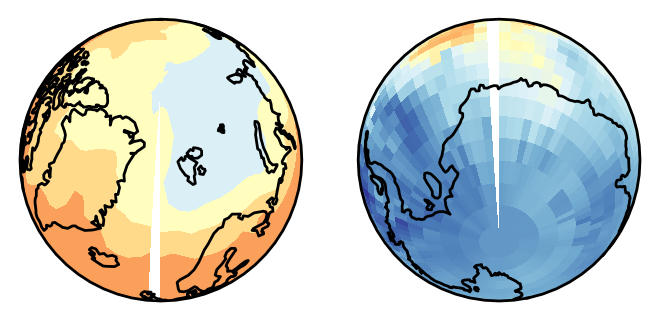

In [21]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon, lat, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon, lat, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

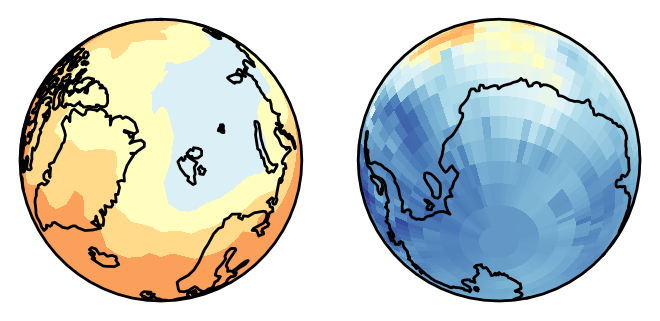

In [22]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon_p, lat_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon_p, lat_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

Test with longiutude_1, llatitude_1 as well:

In [23]:
ucur_r = ds.taux_mm_hyb.isel(t=0).drop("t").isel(hybrid_p_x1000_1=0).drop("hybrid_p_x1000_1")
ucur = transform(ucur_r)

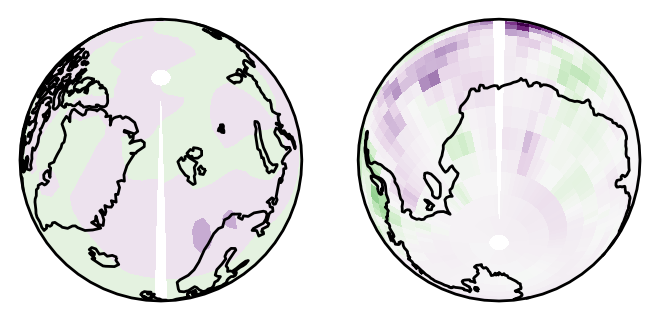

In [24]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb, latb, ucur_r, transform=ccrs.PlateCarree(), cmap="PRGn")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb, latb, ucur_r, transform=ccrs.PlateCarree(), cmap="PRGn")
axSouth.coastlines()
axSouth.set_global()

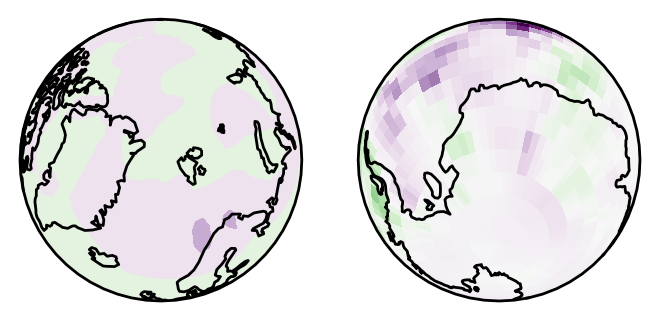

In [25]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb_p, latb_p, ucur, transform=ccrs.PlateCarree(), cmap="PRGn")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb_p, latb_p, ucur, transform=ccrs.PlateCarree(), cmap="PRGn")
axSouth.coastlines()
axSouth.set_global()

**DONE!!!**

### Month ocean (pf)

In [26]:
def transform(array_r):
    array = array_r
    if "longitude" in array.dims:
        array = xr.concat([array, array.isel(longitude=0)], dim="longitude")
    if "longitude_1" in array.dims:
        array = xr.concat([array, array.isel(longitude_1=0)], dim="longitude_1")
    if "latitude" in array.dims:
        array.isel(latitude=-1).values = array.isel(latitude=-2).values
        array = xr.concat([array.isel(latitude=np.arange(0,len(array.latitude)-1,1)), array.isel(latitude=-2),array.isel(latitude=-2)], dim="latitude")
    if "latitude_1" in array.dims:
        array.isel(latitude_1=-1).values = array.isel(latitude_1=-2).values
        array = xr.concat([array.isel(latitude_1=0), array.isel(latitude_1=np.arange(0,len(array.latitude_1)-1,1)), array.isel(latitude_1=-2),array.isel(latitude_1=-2)], dim="latitude_1")
    if "depth_1" in array.dims:
        array = xr.concat([array, array.isel(depth_1=-1)], dim="depth_1")
    return array.transpose(*array_r.dims)

In [27]:
ds = xr.open_dataset("/nfs/see-fs-01_users/eeymr/dump2hold/xosfd/pf/xosfdo#pf000001200ja+.nc")
ds

<xarray.Dataset>
Dimensions:               (depth: 10, depth_1: 10, latitude: 144, latitude_1: 143, longitude: 288, longitude_1: 288, t: 1, unspecified: 1)
Coordinates:
  * longitude             (longitude) float32 0.0 1.25 2.5 ... 357.5 358.75
  * latitude              (latitude) float32 -89.375 -88.125 ... 88.125 89.375
  * depth                 (depth) float32 10.0 20.0 30.0 ... 164.8 242.6 359.4
  * t                     (t) object 1200-01-16 00:00:00
  * unspecified           (unspecified) float32 -1.0
  * longitude_1           (longitude_1) float32 0.625 1.875 ... 358.125 359.375
  * latitude_1            (latitude_1) float32 -88.75 -87.5 ... 87.5 88.75
  * depth_1               (depth_1) float32 5.0 15.0 25.0 ... 138.9 203.7 301.0
Data variables:
    W_mm_dpth             (t, depth, latitude, longitude) float32 ...
    HTN_mm_uo             (t, unspecified, latitude, longitude) float32 ...
    srfSalFlux_mm_uo      (t, unspecified, latitude, longitude) float32 ...
    ucurrTot_mm_dpth      (t, depth_1, latitude_1, longitude_1) float32 ...
    vcurrTot_mm_dpth      (t, depth_1, latitude_1, longitude_1) float32 ...
    srfSalFlux_mm_uo_1    (t, unspecified, latitude, longitude) float32 ...
    uVelSeaice_mm_uo      (t, unspecified, latitude_1, longitude_1) float32 ...
    vVelSeaice_mm_uo      (t, unspecified, latitude_1, longitude_1) float32 ...
    temp_mm_uo            (t, unspecified, latitude, longitude) float32 ...
    temp_mm_dpth          (t, depth_1, latitude, longitude) float32 ...
    salinity_mm_dpth      (t, depth_1, latitude, longitude) float32 ...
    streamFn_mm_uo        (t, unspecified, latitude, longitude) float32 ...
    mixLyrDpth_mm_uo      (t, unspecified, latitude, longitude) float32 ...
    carryheatice_mm_uo    (t, unspecified, latitude, longitude) float32 ...
    OcIceHflux_mm_uo      (t, unspecified, latitude, longitude) float32 ...
    iceconc_mm_uo         (t, unspecified, latitude, longitude) float32 ...
    icedepth_mm_uo        (t, unspecified, latitude, longitude) float32 ...
    WME_mm_uo             (t, unspecified, latitude, longitude) float32 ...
    SOL_mm_uo             (t, unspecified, latitude, longitude) float32 ...
    HTNpenhtflxocn_mm_uo  (t, unspecified, latitude, longitude) float32 ...
    PLE_mm_uo             (t, unspecified, latitude, longitude) float32 ...
    outflow_mm_uo         (t, unspecified, latitude, longitude) float32 ...
    snowfall_mm_uo        (t, unspecified, latitude, longitude) float32 ...
    sublim_mm_uo          (t, unspecified, latitude, longitude) float32 ...
    anomSaltFlux_mm_uo    (t, unspecified, latitude, longitude) float32 ...
Attributes:
    history:  Wed Jun 17 20:17:18 BST 2020 - XCONV V1.91 Development

In [28]:
lon, lonb = np.sort(ds.longitude.values), np.sort(ds.longitude_1.values)
lons = lonb[1:]-lonb[0:-1]
lon_p = np.append(lon,lon[-1]+lons[-1])
lonb_p = np.append(lonb,2*lonb[-1]-lonb[-2])
lons_p = lonb_p[1:]-lonb_p[0:-1]

print(f"lon: [{lon[0]}; {lon[1]}; ... ; {lon[-2]}; {lon[-1]}; {len(lon)}]")
print(f"lon_p: [{lon_p[0]}; {lon_p[1]}; ... ; {lon_p[-2]}; {lon_p[-1]}; {len(lon_p)}]")
print(f"lonb: [{lonb[0]}; {lonb[1]}; ... ; {lonb[-2]}; {lonb[-1]}; {len(lonb)}]")
print(f"lonb_p: [{lonb_p[0]}; {lonb_p[1]}; ... ; {lonb_p[-2]}; {lonb_p[-1]}; {len(lonb_p)}]")
print(f"lons: [{lons[0]}; {lons[1]}; ... ; {lons[-2]}; {lons[-1]}; {len(lons)}]")
print(f"lons_p: [{lons_p[0]}; {lons_p[1]}; ... ; {lons_p[-2]}; {lons_p[-1]}; {len(lons_p)}]")

lon: [0.0; 1.25; ... ; 357.5; 358.75; 288]
lon_p: [0.0; 1.25; ... ; 358.75; 360.0; 289]
lonb: [0.625; 1.875; ... ; 358.125; 359.375; 288]
lonb_p: [0.625; 1.875; ... ; 359.375; 360.625; 289]
lons: [1.25; 1.25; ... ; 1.25; 1.25; 287]
lons_p: [1.25; 1.25; ... ; 1.25; 1.25; 288]


*To do*: test to know if a loop is necessary using lon_s and compute a test for transform. Also, even if it is not a problem on HadCM3, all indexes should be sorted first!

In [29]:
lat, latb = np.sort(ds.latitude.values), np.sort(ds.latitude_1.values)
lats = latb[1:]-latb[0:-1]
lat_p = np.append(lat, lat[-1]+lats[-1])
latb_p = np.concatenate(([2*latb[0]-latb[1]], latb, [2*latb[-1] - latb[-2]]))
lats_p = latb_p[1:]-latb_p[0:-1]

print(f"lat: [{lat[0]}; {lat[1]}; ... ; {lat[-2]}; {lat[-1]}; {len(lat)}]")
print(f"lat_p: [{lat_p[0]}; {lat_p[1]}; ... ; {lat_p[-2]}; {lat_p[-1]}; {len(lat_p)}]")
print(f"latb: [{latb[0]}; {latb[1]}; ... ; {latb[-2]}; {latb[-1]}; {len(latb)}]")
print(f"latb_p: [{latb_p[0]}; {latb_p[1]}; ... ; {latb_p[-2]}; {latb_p[-1]}; {len(latb_p)}]")
print(f"lats: [{lats[0]}; {lats[1]}; ... ; {lats[-2]}; {lats[-1]}; {len(lats)}]")
print(f"lats_p: [{lats_p[0]}; {lats_p[1]}; ... ; {lats_p[-2]}; {lats_p[-1]}; {len(lats_p)}]")

lat: [-89.375; -88.125; ... ; 88.125; 89.375; 144]
lat_p: [-89.375; -88.125; ... ; 89.375; 90.625; 145]
latb: [-88.75; -87.5; ... ; 87.5; 88.75; 143]
latb_p: [-90.0; -88.75; ... ; 88.75; 90.0; 145]
lats: [1.25; 1.25; ... ; 1.25; 1.25; 142]
lats_p: [1.25; 1.25; ... ; 1.25; 1.25; 144]


In [30]:
z, zb = -np.sort(ds.depth.values), -np.sort(ds.depth_1.values)
zs = zb[1:]-zb[0:-1]
z_p = z
zb_p = np.append(zb, zb[-1] + (z[-1] - zb[-1])*2)
zs_p = zb_p[1:]-zb_p[0:-1]

print(f"z: [{z[0]}; {z[1]}; ... ; {z[-2]}; {z[-1]}; {len(z)}]")
print(f"z_p: [{z_p[0]}; {z_p[1]}; ... ; {z_p[-2]}; {z_p[-1]}; {len(z_p)}]")
print(f"zb: [{zb[0]}; {zb[1]}; ... ; {zb[-2]}; {zb[-1]}; {len(zb)}]")
print(f"zb_p: [{zb_p[0]}; {zb_p[1]}; ... ; {zb_p[-2]}; {zb_p[-1]}; {len(zb_p)}]")
print(f"zs: [{zs[0]}; {zs[1]}; ... ; {zs[-2]}; {zs[-1]}; {len(zs)}]")
print(f"zs_p: [{zs_p[0]}; {zs_p[1]}; ... ; {zs_p[-2]}; {zs_p[-1]}; {len(zs_p)}]")

z: [-10.0; -20.0; ... ; -242.60000610351562; -359.3999938964844; 10]
z_p: [-10.0; -20.0; ... ; -242.60000610351562; -359.3999938964844; 10]
zb: [-5.0; -15.0; ... ; -203.6999969482422; -301.0; 10]
zb_p: [-5.0; -15.0; ... ; -301.0; -417.79998779296875; 11]
zs: [-10.0; -10.0; ... ; -64.80000305175781; -97.30000305175781; 9]
zs_p: [-10.0; -10.0; ... ; -97.30000305175781; -116.79998779296875; 10]


plots!

In [31]:
temperature_r = ds.temp_mm_uo.isel(t=0).drop("t").isel(unspecified=0).drop("unspecified")
temperature = transform(temperature_r)

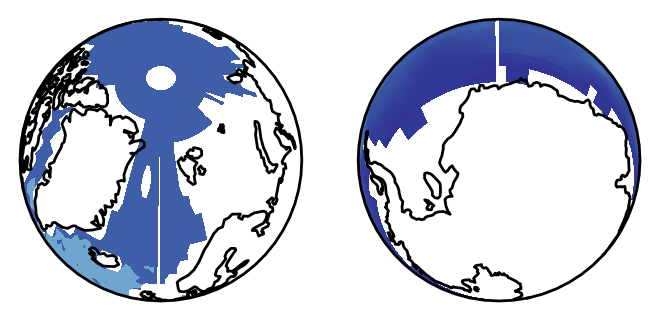

In [32]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon, lat, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon, lat, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

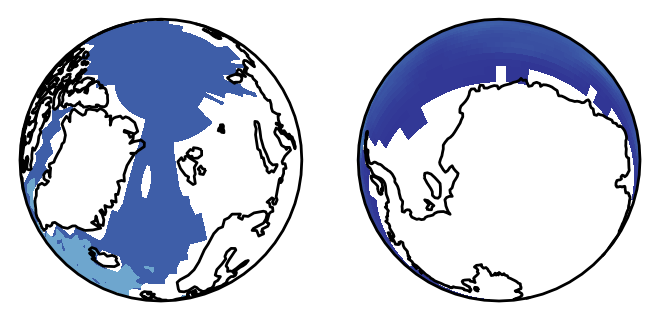

In [33]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon_p, lat_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon_p, lat_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

Does depth works as well?

In [34]:
vel_r = ds.W_mm_dpth.isel(t=0).drop("t").sel(longitude=300).drop("longitude")
vel = transform(vel_r)

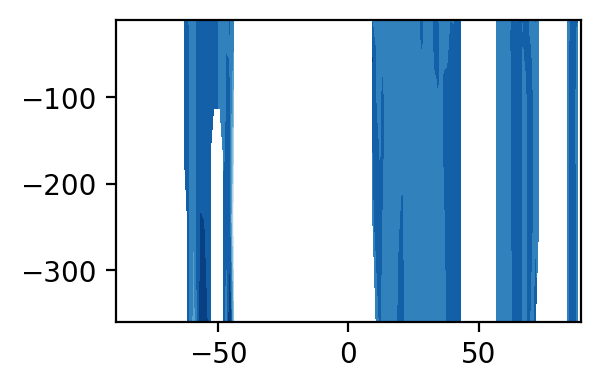

In [35]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(lat, z, vel_r, cmap='Blues')

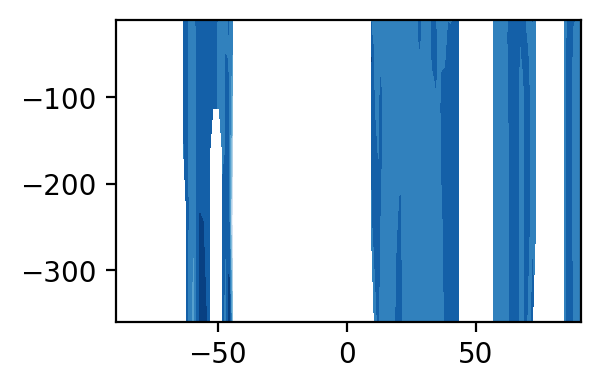

In [36]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(lat_p, z_p, vel, cmap='Blues')

Test with longiutude_1, llatitude_1 and depth_1 as well:

In [37]:
ucur_r = ds.ucurrTot_mm_dpth.isel(t=0).drop("t").isel(depth_1=0).drop("depth_1")
ucur = transform(ucur_r)

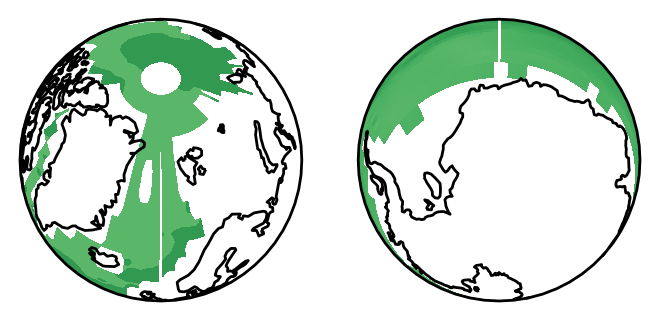

In [38]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb, latb, ucur_r, transform=ccrs.PlateCarree(), cmap="Greens")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb, latb, ucur_r, transform=ccrs.PlateCarree(), cmap="Greens")
axSouth.coastlines()
axSouth.set_global()

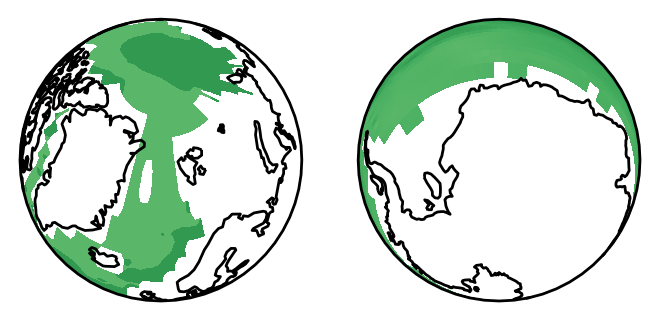

In [39]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb_p, latb_p, ucur, transform=ccrs.PlateCarree(), cmap="Greens")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb_p, latb_p, ucur, transform=ccrs.PlateCarree(), cmap="Greens")
axSouth.coastlines()
axSouth.set_global()

And with depth

In [40]:
ucur_r = ds.ucurrTot_mm_dpth.isel(t=0).drop("t").isel(longitude_1=200).drop("longitude_1")
ucur = transform(ucur_r)

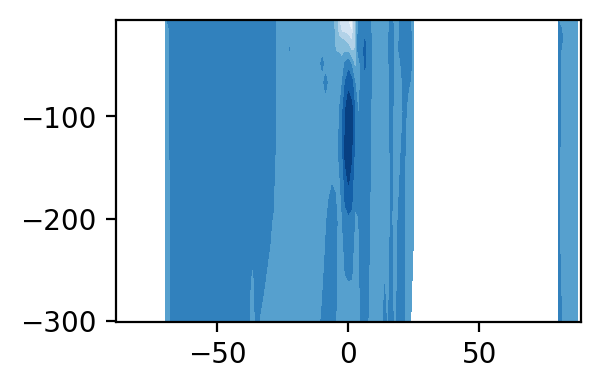

In [41]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(latb, zb, ucur_r, cmap='Blues')

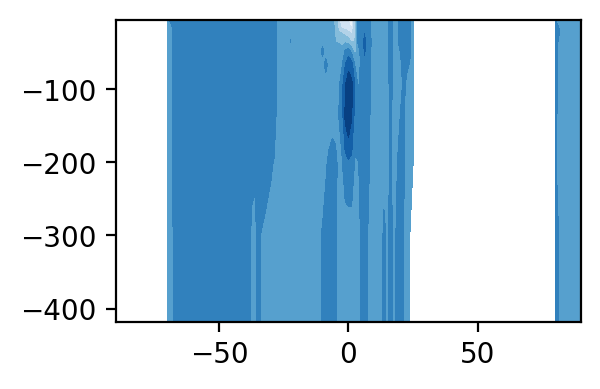

In [42]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(latb_p, zb_p, ucur, cmap='Blues')

**DONE!!!**

### Annual ocean (pg)

Let's start by defining a transfrom method for this dataset. testing if we need to perform the cycling or not.

In [43]:
def transform(array_r):
    array = array_r
    if "longitude" in array.dims:
        array = xr.concat([array, array.isel(longitude=0)], dim="longitude")
    if "longitude_1" in array.dims:
        array = xr.concat([array, array.isel(longitude_1=0)], dim="longitude_1")
    if "latitude" in array.dims:
        array.isel(latitude=-1).values = array.isel(latitude=-2).values
        array = xr.concat([array.isel(latitude=np.arange(0,len(array.latitude)-1,1)), array.isel(latitude=-2),array.isel(latitude=-2)], dim="latitude")
    if "latitude_1" in array.dims:
        array.isel(latitude_1=-1).values = array.isel(latitude_1=-2).values
        array = xr.concat([array.isel(latitude_1=0), array.isel(latitude_1=np.arange(0,len(array.latitude_1)-1,1)), array.isel(latitude_1=-2),array.isel(latitude_1=-2)], dim="latitude_1")
    return array.transpose(*array_r.dims)

In [44]:
ds = xr.open_dataset("/nfs/see-fs-01_users/eeymr/dump2hold/xosfd/pg/xosfdo#pg000001200c1+.nc")
ds

<xarray.Dataset>
Dimensions:             (depth: 19, depth_1: 20, latitude: 144, latitude_1: 143, longitude: 288, longitude_1: 288, t: 1, unspecified: 1)
Coordinates:
  * longitude           (longitude) float32 0.0 1.25 2.5 ... 356.25 357.5 358.75
  * latitude            (latitude) float32 -89.375 -88.125 ... 88.125 89.375
  * depth               (depth) float32 10.0 20.0 30.0 ... 3654.3 4269.5 4884.8
  * t                   (t) object 1200-06-01 00:00:00
  * unspecified         (unspecified) float32 -1.0
  * depth_1             (depth_1) float32 5.0 15.0 25.0 ... 4577.15 5192.45
  * longitude_1         (longitude_1) float32 0.625 1.875 ... 358.125 359.375
  * latitude_1          (latitude_1) float32 -88.75 -87.5 -86.25 ... 87.5 88.75
Data variables:
    W_ym_dpth           (t, depth, latitude, longitude) float32 ...
    srfSalFlux_ym_uo    (t, unspecified, latitude, longitude) float32 ...
    insitu_T_ym_dpth    (t, depth_1, latitude, longitude) float32 ...
    ucurrTot_ym_dpth    (t, depth_1, latitude_1, longitude_1) float32 ...
    vcurrTot_ym_dpth    (t, depth_1, latitude_1, longitude_1) float32 ...
    srfSalFlux_ym_uo_1  (t, unspecified, latitude, longitude) float32 ...
    temp_ym_dpth        (t, depth_1, latitude, longitude) float32 ...
    salinity_ym_dpth    (t, depth_1, latitude, longitude) float32 ...
    otracer14_ym_dpth   (t, depth_1, latitude, longitude) float32 ...
    streamFn_ym_uo      (t, unspecified, latitude, longitude) float32 ...
    mixLyrDpth_ym_uo    (t, unspecified, latitude, longitude) float32 ...
    iceconc_ym_uo       (t, unspecified, latitude, longitude) float32 ...
    icedepth_ym_uo      (t, unspecified, latitude, longitude) float32 ...
    PLE_ym_uo           (t, unspecified, latitude, longitude) float32 ...
    outflow_ym_uo       (t, unspecified, latitude, longitude) float32 ...
    anomSaltFlux_ym_uo  (t, unspecified, latitude, longitude) float32 ...
Attributes:
    history:  Wed Jun 17 20:25:04 BST 2020 - XCONV V1.91 Development

In [45]:
lon, lonb = np.sort(ds.longitude.values), np.sort(ds.longitude_1.values)
lons = lonb[1:]-lonb[0:-1]
lon_p = np.append(lon,lon[-1]+lons[-1])
lonb_p = np.append(lonb,2*lonb[-1]-lonb[-2])
lons_p = lonb_p[1:]-lonb_p[0:-1]

print(f"lon: [{lon[0]}; {lon[1]}; ... ; {lon[-2]}; {lon[-1]}; {len(lon)}]")
print(f"lon_p: [{lon_p[0]}; {lon_p[1]}; ... ; {lon_p[-2]}; {lon_p[-1]}; {len(lon_p)}]")
print(f"lonb: [{lonb[0]}; {lonb[1]}; ... ; {lonb[-2]}; {lonb[-1]}; {len(lonb)}]")
print(f"lonb_p: [{lonb_p[0]}; {lonb_p[1]}; ... ; {lonb_p[-2]}; {lonb_p[-1]}; {len(lonb_p)}]")
print(f"lons: [{lons[0]}; {lons[1]}; ... ; {lons[-2]}; {lons[-1]}; {len(lons)}]")
print(f"lons_p: [{lons_p[0]}; {lons_p[1]}; ... ; {lons_p[-2]}; {lons_p[-1]}; {len(lons_p)}]")

lon: [0.0; 1.25; ... ; 357.5; 358.75; 288]
lon_p: [0.0; 1.25; ... ; 358.75; 360.0; 289]
lonb: [0.625; 1.875; ... ; 358.125; 359.375; 288]
lonb_p: [0.625; 1.875; ... ; 359.375; 360.625; 289]
lons: [1.25; 1.25; ... ; 1.25; 1.25; 287]
lons_p: [1.25; 1.25; ... ; 1.25; 1.25; 288]


*To do*: test to know if a loop is necessary using lon_s and compute a test for transform. Also, even if it is not a problem on HadCM3, all indexes should be sorted first!

In [46]:
lat, latb = np.sort(ds.latitude.values), np.sort(ds.latitude_1.values)
lats = latb[1:]-latb[0:-1]
lat_p = np.append(lat, lat[-1]+lats[-1])
latb_p = np.concatenate(([2*latb[0]-latb[1]], latb, [2*latb[-1] - latb[-2]]))
lats_p = latb_p[1:]-latb_p[0:-1]

print(f"lat: [{lat[0]}; {lat[1]}; ... ; {lat[-2]}; {lat[-1]}; {len(lat)}]")
print(f"lat_p: [{lat_p[0]}; {lat_p[1]}; ... ; {lat_p[-2]}; {lat_p[-1]}; {len(lat_p)}]")
print(f"latb: [{latb[0]}; {latb[1]}; ... ; {latb[-2]}; {latb[-1]}; {len(latb)}]")
print(f"latb_p: [{latb_p[0]}; {latb_p[1]}; ... ; {latb_p[-2]}; {latb_p[-1]}; {len(latb_p)}]")
print(f"lats: [{lats[0]}; {lats[1]}; ... ; {lats[-2]}; {lats[-1]}; {len(lats)}]")
print(f"lats_p: [{lats_p[0]}; {lats_p[1]}; ... ; {lats_p[-2]}; {lats_p[-1]}; {len(lats_p)}]")

lat: [-89.375; -88.125; ... ; 88.125; 89.375; 144]
lat_p: [-89.375; -88.125; ... ; 89.375; 90.625; 145]
latb: [-88.75; -87.5; ... ; 87.5; 88.75; 143]
latb_p: [-90.0; -88.75; ... ; 88.75; 90.0; 145]
lats: [1.25; 1.25; ... ; 1.25; 1.25; 142]
lats_p: [1.25; 1.25; ... ; 1.25; 1.25; 144]


In [47]:
z, zb = -np.sort(ds.depth.values), -np.sort(ds.depth_1.values)
zs = zb[1:]-zb[0:-1]
z_p = z
zb_p = zb
zs_p = zb_p[1:]-zb_p[0:-1]

print(f"z: [{z[0]}; {z[1]}; ... ; {z[-2]}; {z[-1]}; {len(z)}]")
print(f"z_p: [{z_p[0]}; {z_p[1]}; ... ; {z_p[-2]}; {z_p[-1]}; {len(z_p)}]")
print(f"zb: [{zb[0]}; {zb[1]}; ... ; {zb[-2]}; {zb[-1]}; {len(zb)}]")
print(f"zb_p: [{zb_p[0]}; {zb_p[1]}; ... ; {zb_p[-2]}; {zb_p[-1]}; {len(zb_p)}]")
print(f"zs: [{zs[0]}; {zs[1]}; ... ; {zs[-2]}; {zs[-1]}; {len(zs)}]")
print(f"zs_p: [{zs_p[0]}; {zs_p[1]}; ... ; {zs_p[-2]}; {zs_p[-1]}; {len(zs_p)}]")

z: [-10.0; -20.0; ... ; -4269.5; -4884.7998046875; 19]
z_p: [-10.0; -20.0; ... ; -4269.5; -4884.7998046875; 19]
zb: [-5.0; -15.0; ... ; -4577.14990234375; -5192.4501953125; 20]
zb_p: [-5.0; -15.0; ... ; -4577.14990234375; -5192.4501953125; 20]
zs: [-10.0; -10.0; ... ; -615.25; -615.30029296875; 19]
zs_p: [-10.0; -10.0; ... ; -615.25; -615.30029296875; 19]


plots!

In [48]:
temperature_r = ds.temp_ym_dpth.isel(t=0).drop("t").isel(depth_1=0).drop("depth_1")
temperature = transform(temperature_r)

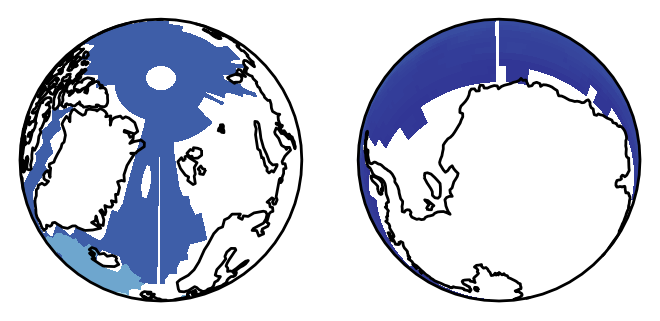

In [49]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon, lat, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon, lat, temperature_r, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

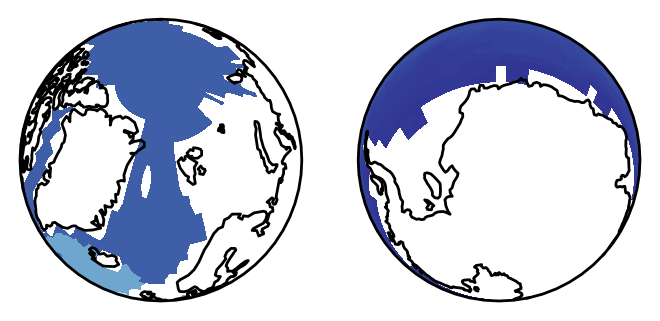

In [50]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon_p, lat_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon_p, lat_p, temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

Does depth works as well?

In [51]:
temperature_r = ds.temp_ym_dpth.isel(t=0).drop("t").sel(longitude=300).drop("longitude")
temperature = transform(temperature_r)

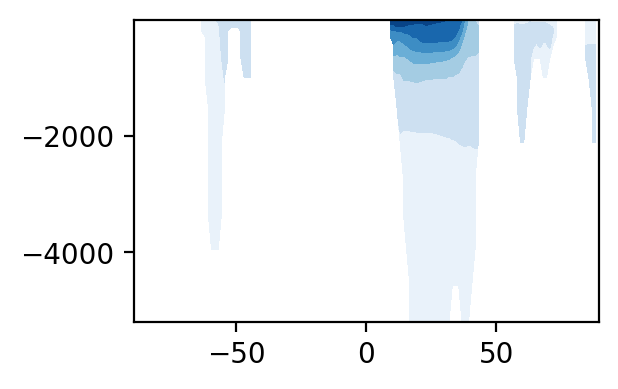

In [52]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(lat, zb, temperature_r, cmap='Blues')

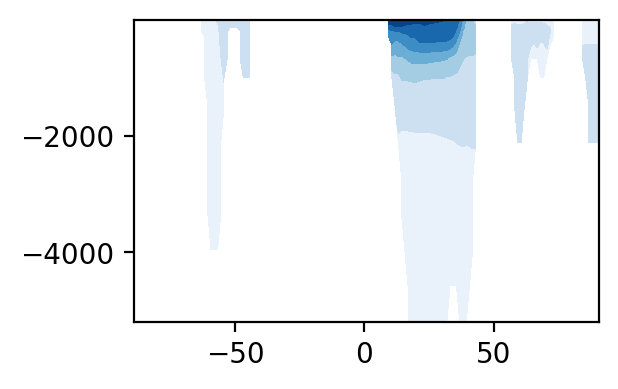

In [53]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(lat_p, zb_p, temperature, cmap='Blues')

Test with longiutude_1, llatitude_1 and depth_1 as well:

In [54]:
ucur_r = ds.ucurrTot_ym_dpth.isel(t=0).drop("t").isel(depth_1=0).drop("depth_1")
ucur = transform(ucur_r)

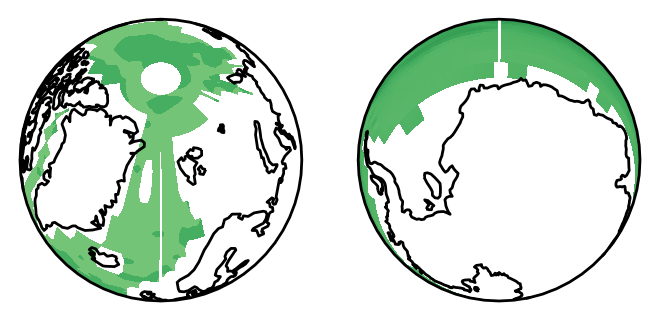

In [55]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb, latb, ucur_r, transform=ccrs.PlateCarree(), cmap="Greens")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb, latb, ucur_r, transform=ccrs.PlateCarree(), cmap="Greens")
axSouth.coastlines()
axSouth.set_global()

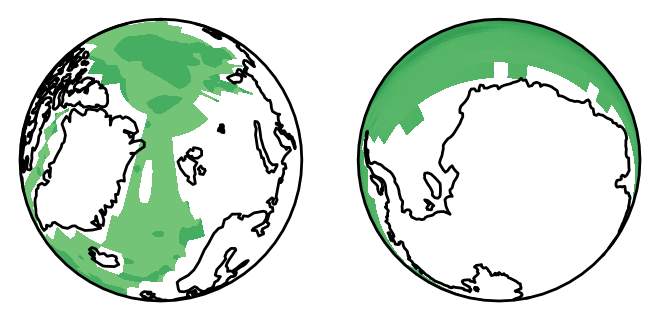

In [56]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(4,2), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lonb_p, latb_p, ucur, transform=ccrs.PlateCarree(), cmap="Greens")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lonb_p, latb_p, ucur, transform=ccrs.PlateCarree(), cmap="Greens")
axSouth.coastlines()
axSouth.set_global()

And with depth

In [57]:
ucur_r = ds.ucurrTot_ym_dpth.isel(t=0).drop("t").isel(longitude_1=200).drop("longitude_1")
ucur = transform(ucur_r)

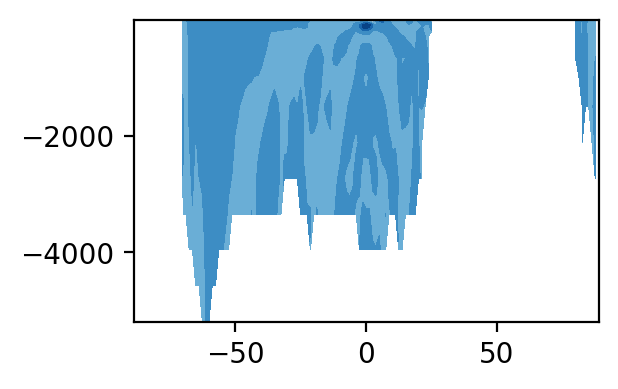

In [58]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(latb, zb, ucur_r, cmap='Blues')

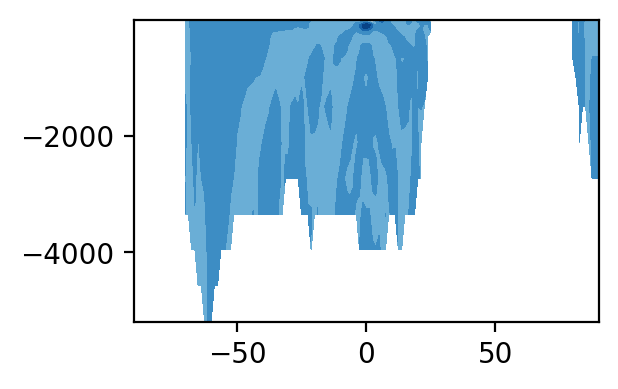

In [59]:
figMap = plt.figure(figsize=(3, 2), dpi=200)
axMap = figMap.add_subplot(1, 1, 1)

axMap.contourf(latb_p, zb_p, ucur, cmap='Blues')

**DONE!!!**

### Tests

In [2]:
ds = hcm3.OCNMDS("xoupb", 1200,1205)

__ Importing <class 'paleoclim_leeds.hadcm3_processing.OCNMDS'>
____ Paths generated for xoupb between years 1200 and 1205.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.


In [3]:
ds

lon: [0.0; 1.25; ...; 357.5; 358.75; 288]; lon_p: [0.0; 1.25; ...; 358.75; 360.0; 289]
lonb: [0.625; 1.875; ...; 358.125; 359.375; 288]; lonb_p: [0.625; 1.875; ...; 359.375; 360.625; 289]
lons: [1.25; 1.25; ...; 1.25; 1.25; 287]; lons_p: [1.25; 1.25; ...; 1.25; 1.25; 288]
lat: [-89.375; -88.125; ...; 88.125; 89.375; 144]; lat_p: [-89.375; -88.125; ...; 89.375; 90.625; 145]
latb: [-88.75; -87.5; ...; 87.5; 88.75; 143]; latb_p: [-90.0; -88.75; ...; 88.75; 90.0; 145]
lats: [1.25; 1.25; ...; 1.25; 1.25; 142]; lats_p: [1.25; 1.25; ...; 1.25; 1.25; 144]
z: [-10.0; -20.0; ...; -242.60000610351562; -359.3999938964844; 10]; z_p: [-10.0; -20.0; ...; -242.60000610351562; -359.3999938964844; 10]
zb: [-5.0; -15.0; ...; -203.6999969482422; -301.0; 10]; zb_p: [-5.0; -15.0; ...; -301.0; -417.79998779296875; 11]
zs: [-10.0; -10.0; ...; -64.80000305175781; -97.30000305175781; 9]; zs_p: [-10.0; -10.0; ...; -97.30000305175781; -116.79998779296875; 10]
t: [1200-06-01 00:00:00; 1201-06-01 00:00:00; ...; 120

In [4]:
ds.sst(mode_lon="value", value_lon=285.244)

__ Importing SST.
____ Data imported in the GeoDataArray instance.
____ Coordinate imported in the GeoDataArray instance.
____ New longitude value : 285.0


lon: [285.0; 1]; lon_p: [285.0; 1]
lonb: [285.0; 1]; lonb_p: [285.0; 1]
lons: None; lons_p: None
lat: [-89.375; -88.125; ...; 88.125; 89.375; 144]; lat_p: [-89.375; -88.125; ...; 89.375; 90.625; 145]
latb: [-88.75; -87.5; ...; 87.5; 88.75; 143]; latb_p: [-90.0; -88.75; ...; 88.75; 90.0; 145]
lats: [1.25; 1.25; ...; 1.25; 1.25; 142]; lats_p: [1.25; 1.25; ...; 1.25; 1.25; 144]
z: [0.0; 1.25; ...; 357.5; 358.75; 288]; z_p: [-10.0; -20.0; ...; -242.60000610351562; -359.3999938964844; 10]
zb: [-5.0; -15.0; ...; -203.6999969482422; -301.0; 10]; zb_p: [-5.0; -15.0; ...; -301.0; -417.79998779296875; 11]
zs: [-10.0; -10.0; ...; -64.80000305175781; -97.30000305175781; 9]; zs_p: [-10.0; -10.0; ...; -97.30000305175781; -116.79998779296875; 10]
t: None
DATA: <xarray.DataArray 'temp_mm_uo' (t: 72, latitude: 144)>
array([[       nan,        nan,        nan, ..., -1.7381427, -1.7606367,
               nan],
       [       nan,        nan,        nan, ..., -1.7245136, -1.7595122,
               nan],
 

In [17]:
ds.lon[np.where(ds.lon>=145)]

array([145.  , 146.25, 147.5 , 148.75, 150.  , 151.25, 152.5 , 153.75,
       155.  , 156.25, 157.5 , 158.75, 160.  , 161.25, 162.5 , 163.75,
       165.  , 166.25, 167.5 , 168.75, 170.  , 171.25, 172.5 , 173.75,
       175.  , 176.25, 177.5 , 178.75, 180.  , 181.25, 182.5 , 183.75,
       185.  , 186.25, 187.5 , 188.75, 190.  , 191.25, 192.5 , 193.75,
       195.  , 196.25, 197.5 , 198.75, 200.  , 201.25, 202.5 , 203.75,
       205.  , 206.25, 207.5 , 208.75, 210.  , 211.25, 212.5 , 213.75,
       215.  , 216.25, 217.5 , 218.75, 220.  , 221.25, 222.5 , 223.75,
       225.  , 226.25, 227.5 , 228.75, 230.  , 231.25, 232.5 , 233.75,
       235.  , 236.25, 237.5 , 238.75, 240.  , 241.25, 242.5 , 243.75,
       245.  , 246.25, 247.5 , 248.75, 250.  , 251.25, 252.5 , 253.75,
       255.  , 256.25, 257.5 , 258.75, 260.  , 261.25, 262.5 , 263.75,
       265.  , 266.25, 267.5 , 268.75, 270.  , 271.25, 272.5 , 273.75,
       275.  , 276.25, 277.5 , 278.75, 280.  , 281.25, 282.5 , 283.75,
      

In [10]:
np.where(ds.lonb>=145)

(array([116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
        207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
        233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
        285, 286, 287]),)

### Weights matrix

**Surface mean**

In [60]:
temperature.shape


(20, 145)

In [61]:
lon_p.shape

(289,)

In [62]:
lat_p.shape

(145,)

In [63]:
def cell_area(n_lon, lat1, lat2):
    """
    Area of a cell on a regular lon-lat grid.
    :param n_lon: number of longitude divisions
    :param lat1: bottom of the cell
    :param lat2: top of the cell
    :return:
    """
    r = 6371000
    lat1_rad, lat2_rad = 2 * np.pi * lat1 / 360, 2 * np.pi * lat2 / 360
    return 2 * np.pi * r ** 2 * np.abs(np.sin(lat1_rad) - np.sin(lat2_rad)) / n_lon

In [64]:
def surface_matrix(lon_b, lat_b):
    """
    Compute a matrix with all the surfaces values.
    :param lon:
    :param lat:
    :return:
    """
    n_j, n_i = len(lat_b) -1 , len(lon_b)
    surface = np.zeros((n_j, n_i))
    for i in range(n_i):
        for j in range(n_j):
            surface[j, i] = cell_area(n_i, lat_b[j], lat_b[j + 1])
    return surface

# NOT SURE about LON_B DIMENSION!!

In [65]:
matrix = surface_matrix(lon_b, lat_b)

NameError: name 'lon_b' is not defined

In [ ]:
projection_north = ccrs.NearsidePerspective(central_longitude=0, central_latitude=80, satellite_height=1000000)
projection_south = ccrs.NearsidePerspective(central_longitude=0, central_latitude=-80, satellite_height=1000000)

figMap = plt.figure(figsize=(7,3), dpi = 200)
axNorth = figMap.add_subplot(1, 2, 1, projection=projection_north)
axSouth = figMap.add_subplot(1, 2, 2, projection=projection_south)

axNorth.contourf(lon_p, lat_p, matrix*temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axNorth.coastlines()
axNorth.set_global()
axSouth.pcolormesh(lon_p, lat_p, matrix*temperature, transform=ccrs.PlateCarree(), cmap="RdYlBu_r")
axSouth.coastlines()
axSouth.set_global()

In [ ]:
ds = xr.open_dataset("/nfs/see-fs-01_users/eeymr/database/xosfd/time_series/xosfd.oceantemppg.annual.nc")
ds

In [ ]:
start_year = 2552
end_year = 2700

ds = hcm3.OCNYDS("xosfa", start_year, end_year)

temperature = ds.temperature(mode_lat="mean", mode_lon="mean", mode_z="mean")
temperature_values = temperature.values(processing=False)
t_temperature = np.linspace(ds.start_year, ds.end_year, len(ds.t))

ds

In [ ]:
n_z = len(ds.z)
z = ds.z
z

In [ ]:
z_bounds = np.zeros((n,2))
dz = np.zeros(n)
dz[0] = z[0]
for i in range(0,n-1):
    dz[i+1] = z[i+1] - z[i]
    z_bounds[i,0] = z[i]-dz[i]/2
    z_bounds[i,1] = z[i]+dz[i+1]/2
z_bounds[-1,0] = z_bounds[-2,1]
z_bounds[-1,1] = z_bounds[-1,0] + dz[-1]

In [ ]:
dz

In [ ]:
z_bounds

In [ ]:
n_lon = len(ds.lon)
lon = ds.lon
lon

In [ ]:
lon_bounds = np.zeros((n_lon,2))
dlon = np.zeros(n_lon)
dlon[0] = lon[0]
for i in range(0,n_lon-1):
    dlon[i+1] = lon[i+1] - lon[i]
    lon_bounds[i,0] = lon[i]-dlon[i]/2
    lon_bounds[i,1] = lon[i]+dlon[i+1]/2
lon_bounds[-1,0] = lon_bounds[-2,1]
lon_bounds[-1,1] = lon_bounds[-1,0] + dlon[-1]

In [ ]:
dlon

In [ ]:
lon_bounds

In [ ]:
dz = z_bounds[:,1]-z_bounds[:,0] # layer thickness

max_depth = z_bounds[-1,-1] # last cell of the tab is the max



grid_areas = iris.analysis.cartography.area_weights(vertical_weighted_mean)

In [ ]:
ds = xr.open_dataset("/nfs/see-fs-01_users/eeymr/database/xosfd/time_series/xosfd.oceantemppg.annual.nc")
ds

In [ ]:
array = ds.temp_ym_dpth
array.t

In [ ]:
mean = array.mean()
mean

In [ ]:
n_lon = len
weights = np.ones()

In [ ]:
array = np.array([[0,1,2],[3,4,5]])
array